CS 178 Project <br>
Team 69 - "Adulting" <br>
Members:<br>
Dingyi Chang #89167697<br>
Nicholas King #33099364<br>
Jenny My Lee #<br>

We will first download the data (the Adult dataset from UCI ML Repo) as well as importing any necessary libraries.

In [66]:
#Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.tree as tree
from sklearn import preprocessing
from sklearn.metrics import zero_one_loss

In [65]:
#Gather and encode data
tr_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
val_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

le = preprocessing.LabelEncoder()

data = np.array(pd.read_csv(tr_url, header = None))
for i, j in enumerate([1, 3, 5, 6, 7, 8, 9, 13, 14]):
    le.fit(data[:, j])
    data[:, j] = le.transform(data[:, j])
Xtr = data[:, :14].astype('int')
Ytr = data[:, 14].astype('int')

#Read testing data from adult.test and make Xte and Yte
data = np.array(pd.read_csv(val_url, header = None, skiprows = 1))
for i, j in enumerate([1, 3, 5, 6, 7, 8, 9, 13, 14]):
    le.fit(data[:, j])
    data[:, j] = le.transform(data[:, j])
Xval = data[:, :14].astype('int')
Yval = data[:, 14].astype('int')



Since we are using nominal data, it may be a good idea to implement a decision tree as our machine learning model. The code below will implement a decision tree model at different max depths, $d \in \{1,...,50\}$, and plots the training and validation error.

0.1435


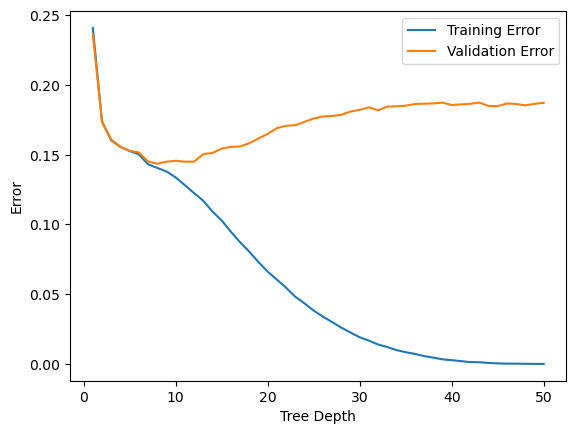

In [69]:


d = list(range(1, 51))   #Depth values for our decision

#Arrays to store training and validation error
tree_te = []
tree_ve = []

#Implement decision trees
for i in d:
    learner = tree.DecisionTreeClassifier(max_depth = i, criterion ='entropy')
    learner.fit(Xtr, Ytr)
    tree_te.append(np.round(zero_one_loss(learner.predict(Xtr), Ytr), 4))
    tree_ve.append(np.round(zero_one_loss(learner.predict(Xval), Yval), 4))

plt.plot(d, tree_te)
plt.plot(d, tree_ve)
plt.legend(["Training Error", "Validation Error"])
plt.xlabel("Tree Depth")
plt.ylabel("Error")

What we notice from the graph is that the optimal range for our tree at around $7\leq d\leq 12$, with values inside that range having validation error of under ``0.15``. The best model performing tree is at $d=8$ with training error of ``0.1404`` and validation error of ``0.1435``. 